In [1]:
import os
import sys
import numpy as np
import torch
import torch.nn.functional as F
import onnxruntime as ort
from nostril import nonsense_detector as nd
from torch import nn
from torch.utils.data import Dataset
from transformers import BertTokenizer

current_notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from model_creation.scripts.ml_helpers import train_test_loop, split_data
from model_creation.scripts.data_helpers import get_bias_data, display_bias_data, process_text
from model_creation.schemas.bias import sources, index_to_bias

c:\.Work\projects\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def map_label_to_class(label):
  for class_label, source in sources.items():
    if label in source:
        return class_label
  raise ValueError(f"Label '{label}' not found in any source categories.")


def process_data(df):
  df['text'] = df['text'].apply(process_text)
  df['source'] = df['source'].apply(map_label_to_class)
  df.drop(columns=['id'])
  return df

In [3]:
# dataset initialization
class FBData(Dataset):
  def __init__(self,df,device):
    df.drop(columns=['id'])
    self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    self.data = df
    self.device = device
  
  def __len__(self):
    return len(self.data)

  def __getitem__(self,idx):
    text = self.data['text'][idx]
    label = self.data['source'][idx]
    vectorized_text = self.tokenizer(
      text,
      return_tensors='pt',
      truncation=True,
      )
    input = vectorized_text['input_ids'].squeeze(0)
    return input.to(self.device),torch.tensor(label).to(self.device)

In [4]:
# model
class BiasClassificationModel(nn.Module):
  def __init__(self,input_size,embed_dim,hidden_dim_1,num_class):
    super(BiasClassificationModel,self).__init__()
    self.embed = nn.EmbeddingBag(input_size,embed_dim)
    self.fc1 = nn.Linear(embed_dim, hidden_dim_1)
    self.fc2 = nn.Linear(hidden_dim_1, num_class)
    self.relu = nn.LeakyReLU()
  
  def forward(self,text):
    embed = self.embed(text)
    output = self.relu(self.fc1(embed))
    output = self.fc2(output)
    return F.softmax(output,dim=1)

In [5]:
# predict
def predict_text(text,session,dataset):
  text = process_text(text)
  vectorized_text = dataset.tokenizer(
      text,
      return_tensors='np',
      truncation=True,
      )
  onnx_input = {
    'input' : vectorized_text['input_ids'].astype(np.int32)
  }
  output = session.run(None,onnx_input)[0][0]
  prediction = output.argmax()

  prediction = index_to_bias.get(prediction, 'Prediction error.')
  probabilities_percentage = [f"{p * 100:.1f}%" for p in output]

  print(f'The text provided leans towards {prediction} with a probability of '
          f'{probabilities_percentage[0]} for left, {probabilities_percentage[1]} for right, and '
          f'{probabilities_percentage[2]} for center.')

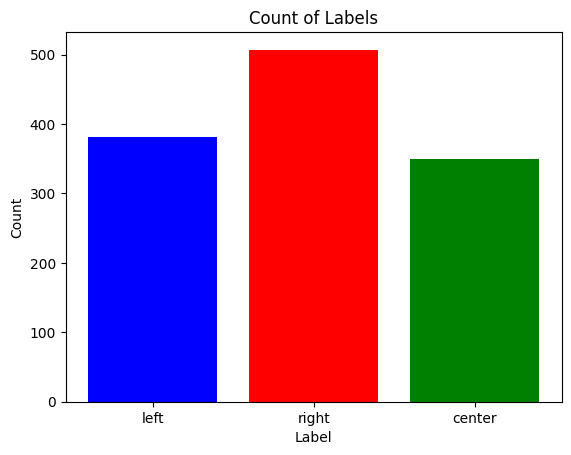

cuda
Training Classification NN Starting


100%|██████████| 99/99 [00:01<00:00, 63.36it/s]


Training Epoch [1/10], Loss: 0.1081, Accuracy: 0.4293


100%|██████████| 25/25 [00:00<00:00, 111.34it/s]


Test Epoch [1/10], Loss: 0.1096, Accuracy: 0.4032


100%|██████████| 99/99 [00:01<00:00, 69.79it/s]


Training Epoch [2/10], Loss: 0.1062, Accuracy: 0.4667


100%|██████████| 25/25 [00:00<00:00, 107.46it/s]


Test Epoch [2/10], Loss: 0.1081, Accuracy: 0.4274


100%|██████████| 99/99 [00:01<00:00, 69.34it/s]


Training Epoch [3/10], Loss: 0.1007, Accuracy: 0.5374


100%|██████████| 25/25 [00:00<00:00, 99.39it/s] 


Test Epoch [3/10], Loss: 0.1026, Accuracy: 0.4839


100%|██████████| 99/99 [00:01<00:00, 69.21it/s]


Training Epoch [4/10], Loss: 0.0926, Accuracy: 0.6263


100%|██████████| 25/25 [00:00<00:00, 101.07it/s]


Test Epoch [4/10], Loss: 0.0945, Accuracy: 0.6089


100%|██████████| 99/99 [00:01<00:00, 73.15it/s]


Training Epoch [5/10], Loss: 0.0868, Accuracy: 0.6919


100%|██████████| 25/25 [00:00<00:00, 113.85it/s]


Test Epoch [5/10], Loss: 0.0935, Accuracy: 0.5847


100%|██████████| 99/99 [00:01<00:00, 72.12it/s]


Training Epoch [6/10], Loss: 0.0808, Accuracy: 0.7616


100%|██████████| 25/25 [00:00<00:00, 111.27it/s]


Test Epoch [6/10], Loss: 0.0876, Accuracy: 0.6653


100%|██████████| 99/99 [00:01<00:00, 67.57it/s]


Training Epoch [7/10], Loss: 0.0755, Accuracy: 0.8313


100%|██████████| 25/25 [00:00<00:00, 102.81it/s]


Test Epoch [7/10], Loss: 0.0889, Accuracy: 0.6492


100%|██████████| 99/99 [00:01<00:00, 71.58it/s]


Training Epoch [8/10], Loss: 0.0728, Accuracy: 0.8414


100%|██████████| 25/25 [00:00<00:00, 103.21it/s]


Test Epoch [8/10], Loss: 0.0894, Accuracy: 0.6411


100%|██████████| 99/99 [00:01<00:00, 72.26it/s]


Training Epoch [9/10], Loss: 0.0685, Accuracy: 0.8949


100%|██████████| 25/25 [00:00<00:00, 114.48it/s]


Test Epoch [9/10], Loss: 0.0843, Accuracy: 0.7218


100%|██████████| 99/99 [00:01<00:00, 71.75it/s]


Training Epoch [10/10], Loss: 0.0668, Accuracy: 0.9091


100%|██████████| 25/25 [00:00<00:00, 109.04it/s]


Test Epoch [10/10], Loss: 0.0828, Accuracy: 0.7339
Model Saved - Training Done, Final Testing Results Are As Shown:
Training Epoch [10/10], Loss: 0.0668, Accuracy: 0.9091
Test Epoch [10/10], Loss: 0.0828, Accuracy: 0.7339


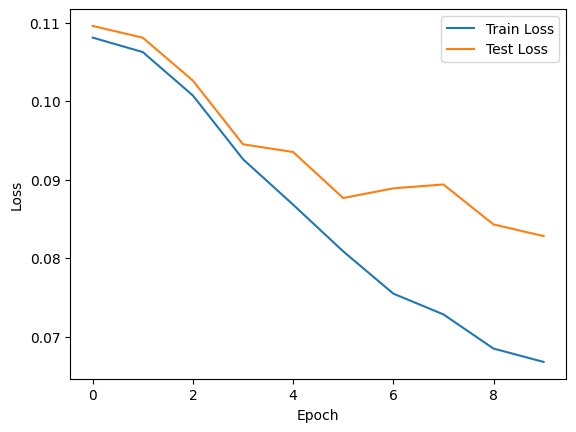

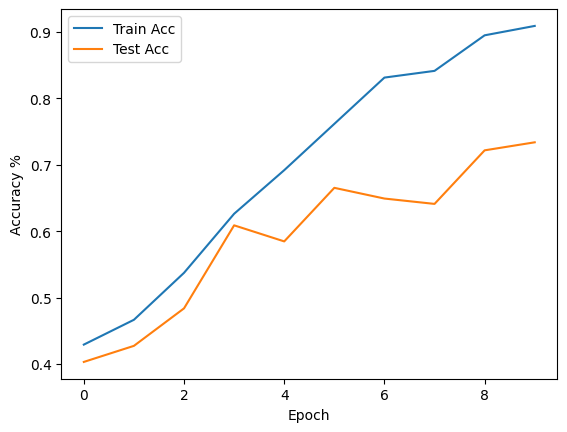

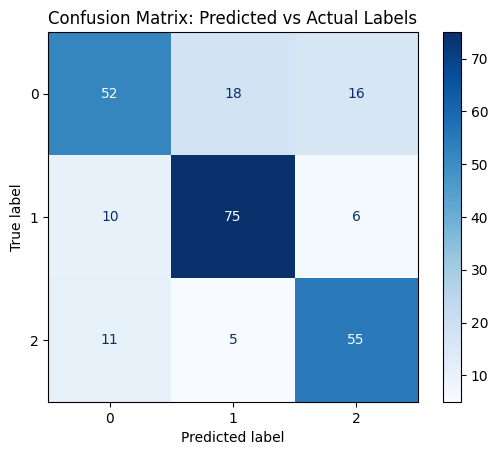

The text provided leans towards right with a probability of 0.0% for left, 98.9% for right, and 1.1% for center.


In [6]:
def main(text,batch_size,num_epochs,verbose,override):
  device = ('cuda' if torch.cuda.is_available() else 'cpu')

  if nd.nonsense(text):
    raise Exception("Gibberish Text Detected") 
  
  nn_path = '../models/bias'

  df = get_bias_data()
  df = process_data(df)
  
  if (override and verbose):
    display_bias_data(df)
    print(device)
  
  dataset = FBData(df,device)
  train_loader, test_loader = split_data(dataset,batch_size)

  input_size = dataset.tokenizer.vocab_size
  embed_dim = 256
  hidden_dim_1 = 64
  num_classes = 3
  model = BiasClassificationModel(input_size,embed_dim,hidden_dim_1,num_classes).to(device)

  if(override):
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
    criterion = torch.nn.CrossEntropyLoss()
    train_test_loop(nn_path,device,train_loader,test_loader,num_epochs,model,optimizer,criterion,verbose)

  model_path = '../models/bias_model_67.onnx'
  session = ort.InferenceSession(model_path)
  if(text is not None):
    predict_text(text,session,dataset)

text = "test text test text test text"
main(text,batch_size=10,num_epochs=10,verbose=True,override=True)